In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import load_model
from tensorflow import keras
import matplotlib.cm as cm


In [2]:
from sklearn.model_selection import train_test_split


def split_dataset(ds,name,train_dir,valid_dir,test_dir):
    main_directory_name = os.path.join(ds, name)
    
# Set the paths for the train and test directories
    train_dir = train_dir
    valid_dir = valid_dir
    test_dir =  test_dir
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)
    train_dir_name = os.path.join(train_dir, name)
    test_dir_name = os.path.join(test_dir, name)
    valid_dir_name = os.path.join(valid_dir, name)
    os.makedirs(test_dir_name, exist_ok=True)
    os.makedirs(train_dir_name, exist_ok=True)
    os.makedirs(valid_dir_name, exist_ok=True)
# Get the list of image file names in the training directory
    image_files = os.listdir(main_directory_name)

# Split the image file names into train and test sets
    train_files, test_files = train_test_split(image_files, test_size=0.3, random_state=42)
    valid_files, test_files = train_test_split(test_files, test_size=0.16, random_state=42)

# Move the train files to the train directory
    for file_name in train_files:
        src_path = os.path.join(main_directory_name, file_name)
        dst_path = os.path.join(train_dir_name, file_name)
        shutil.copy(src_path, dst_path)

# Move the test files to the test directory
    for file_name in valid_files:
        src_path = os.path.join(main_directory_name, file_name)
        dst_path = os.path.join(valid_dir_name, file_name)
        shutil.copy(src_path, dst_path)
        
    for file_name in test_files:
        src_path = os.path.join(main_directory_name, file_name)
        dst_path = os.path.join(test_dir_name, file_name)
        shutil.copy(src_path, dst_path)

In [3]:
from keras.utils import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator 

def mod_photos(imgdir,outdir,prefix_type):
    output = []
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    os.makedirs(outdir, exist_ok=True)


    for imgs in os.listdir(imgdir):

        img = load_img(os.path.join(imgdir,imgs))
        x = img_to_array(img)  
        x = x.reshape((1,) + x.shape)  
        print(x.shape)
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
        i = 0
        for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=outdir, save_prefix=prefix_type, save_format='jpeg'):
            i += 1
            if i > 19:
                break  # otherwise the generator would loop indefinitely
            
            
    file_list = os.listdir(outdir)
    for i in file_list:
        output.append((i,1))


In [4]:
import shutil
def oragnize_file(dir_path):
# Specify the directory containing the files
    directory = dir_path

# Create the new subdirectory "0"
    box_directory = os.path.join(directory, '0')
    damaged_directory = os.path.join(directory, '1')
    os.makedirs(box_directory, exist_ok=True)
    os.makedirs(damaged_directory, exist_ok=True)

# Iterate through all files in the directory
    for file_name in os.listdir(directory):
        if 'Mailer' in file_name:
            # Get the current file path
            file_path = os.path.join(directory, file_name)
        
        # Move the file to the new subdirectory "0"
            shutil.move(file_path, box_directory)

        if 'Damaged' in file_name:
            # Get the current file path
            file_path = os.path.join(directory, file_name)
        
        # Move the file to the new subdirectory "1"
            shutil.move(file_path, damaged_directory)

In [5]:

def load_dataset(IMG_SIZE,batch_size):

    target_size = (IMG_SIZE, IMG_SIZE) 
    datagen = ImageDataGenerator(
    rescale=1./255,
)
    train_dataset = datagen.flow_from_directory(
    directory=mod_train,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True
)
    
    folder_0 = os.path.join(valid_dir,"0")
    folder_1 = os.path.join(valid_dir,"1")

# Generate the validation dataset
    valid_dataset = datagen.flow_from_directory(
    directory=valid_dir,
    target_size=target_size,
    batch_size=len(os.listdir(folder_0)) + len(os.listdir(folder_1)),
    class_mode='categorical',
    shuffle=True
)

    
    
    folder_0 = os.path.join(mod_test,"0")
    folder_1 = os.path.join(mod_test,"1")
    num_images = len(os.listdir(folder_0)) + len(os.listdir(folder_1))
    test_dataset = datagen.flow_from_directory(
    directory=mod_test,
    target_size=target_size,
    batch_size=num_images,
    class_mode='categorical',
    shuffle=True
)
    return train_dataset,valid_dataset,test_dataset

In [6]:
def build_dense(hp):

    base_model = keras.applications.DenseNet169(
    weights="imagenet",  
    input_shape=(150, 150, 3),
    include_top=False,
)  

    # Freeze the base_model
    base_model.trainable = False

# Create new model on top
#     inputs = keras.Input(shape=(150, 150, 3))
# x = inputs
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`


    inputs = base_model.input
    # base_model is running in inference mode here.
    
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    x = layers.Dense(512, activation = 'relu')(x)
    x = layers.Dense(512, activation = 'relu')(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)
    model = keras.Model(inputs, outputs)
    
    optimizer_name = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    
    # Define the learning rate range
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001, 0.00001 ])
    
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [7]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


def build_xception(hp):

    base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
) 

    # Freeze the base_model
    base_model.trainable = False

# Create new model on top
#     inputs = keras.Input(shape=(150, 150, 3))
# x = inputs
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`


    inputs = base_model.input
    # base_model is running in inference mode here.
    
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    x = layers.Dense(512, activation = 'relu')(x)
    x = layers.Dense(512, activation = 'relu')(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)
    model = keras.Model(inputs, outputs)
    
    optimizer_name = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    
    # Define the learning rate range
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001, 0.00001 ])
    
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [8]:
from keras_tuner import GridSearch
def tune_hyps():
    train_dataset,valid_dataset,test_dataset = load_dataset(IMG_SIZE,batch_size)

    tuner = GridSearch(build_xception, objective='val_accuracy', overwrite=True)

# Perform the grid search
    tuner.search(train_dataset,validation_data=valid_dataset, epochs=2)

# Get the best hyperparameters and build the best model
    best_hps_xception = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_Xception = tuner.hypermodel.build(best_hps_xception)
    tuner_2 = GridSearch(build_dense, objective='val_accuracy', overwrite=True)

# Perform the grid search
    tuner_2.search(train_dataset,validation_data=valid_dataset, epochs=2)

# Get the best hyperparameters and build the best model
    best_hps_dense = tuner_2.get_best_hyperparameters(num_trials=1)[0]
    best_dense = tuner_2.hypermodel.build(best_hps_dense)
    return best_dense, best_Xception


In [9]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

In [10]:
from datetime import datetime
def name_model(model,model_type):
    # Get the current date
    current_date = datetime.now()

    # Format the date as a string with "dd_mm_yy" format
    formatted_date = current_date.strftime("%d_%m_%y")
    model_name = model_type + formatted_date + ".h5"
    pw = os.getcwd()
    os.makedirs('model', exist_ok=True)
    model.save(os.path.join(pw,"model",model_type, model_name))

In [11]:
def run_train(epochs, lr,model,train_dataset,valid_dataset):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) # 1e-2 for full connected layer,1e-4 for fine tuning
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


    epochs = epochs
    hist = model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset,verbose=0)
    return hist

In [12]:
def get_model():
    xception, dense = tune_hyps()
    train_dataset,valid_dataset,test_dataset = load_dataset(IMG_SIZE,batch_size)
    print("############################  Training Xception Model:  #########################")
    hist = xception.fit(train_dataset, validation_data=valid_dataset, epochs=5,verbose=0)
    print("##################################### Done ######################################")
    print("############################  Fine Tuning Xception Model:  ######################")
    unfreeze_model(xception)
    finetuned_xception = run_train(10,1e-4,xception,train_dataset,valid_dataset)
    print("##################################### Done ######################################")
    name_model(xception,"xception")
    print("############################  Training DenseNet Model:  #########################")
    densenet = dense.fit(train_dataset, validation_data=valid_dataset, epochs=5,verbose=0)
    print("##################################### Done ######################################")
    print("############################  Fine Tuning DenseNet Model:  ######################")
    unfreeze_model(dense)
    finetuned_densenet = run_train(10,1e-4,dense,train_dataset,valid_dataset)
    print("##################################### Done ######################################")
    name_model(dense,"dense")
    return hist,finetuned_xception,densenet,finetuned_densenet

In [13]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
def plot_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [14]:
import numpy as np
from sklearn.metrics import f1_score


def precision_recall(labels, preds):
    true_positive = 0
    false_negative = 0
    false_positive = 0
    l = len(preds)
    
    for num,i in enumerate(preds):
        prediction = np.argmax(i)
        if labels[num][1] == 1 and prediction == 1:
            true_positive += 1
        elif labels[num][1] == 1 and prediction == 0:
            false_negative += 1
        
        if labels[num][1] == 0 and prediction == 1:
            false_positive += 1
            
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    
    labels_max = np.argmax(labels, axis=1)
    preds_max = np.argmax(preds, axis=1)

    f1 = f1_score(labels_max, preds_max)

    
    print(f"Length of dataset: {l}")
    print("Precision: {:.1f}%".format(precision*100))
    print("Recall: {:.1f}%".format(recall*100))
    print("F1 Score: {:.1f}%".format(f1*100))

In [15]:
def ensemble_predict(x_test,xception,densenet):
    trained_densenet_model=load_model(densenet)
    trained_xception_model=load_model(xception)

    # Get predictions from both models
    densenet_predictions = trained_densenet_model.predict(x_test)
    xception_predictions = trained_xception_model.predict(x_test)

    # Combine predictions using averaging
    ensemble_predictions = (densenet_predictions + xception_predictions) / 2

    # Convert predictions to class labels
    #ensemble_predictions_classes = np.argmax(ensemble_predictions, axis=1)

    # Calculate accuracy
    return ensemble_predictions

In [16]:
def prepare_data(ds,mod=True):
    split_dataset(ds,'0',train_dir,valid_dir,test_dir)
    split_dataset(ds,'1',train_dir,valid_dir,test_dir)
    mod_photos(os.path.join(train_dir, '0'),mod_train,'Mailer')
    mod_photos(os.path.join(train_dir, '1'),mod_train,'Damaged')
    mod_photos(os.path.join(test_dir, '0'),mod_test,'Mailer')
    mod_photos(os.path.join(test_dir, '1'),mod_test,'Damaged')
    oragnize_file(mod_train)
    oragnize_file(mod_test)

In [17]:

def get_img_array(img_path, size):

    size = (150,150)
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (150, 150, 3)
    array = keras.utils.img_to_array(img)
    array = array / 255.0
    # We add a dimension to transform our array into a "batch"
    # of size (1, 150, 150, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))


# last_conv_layer_name = "relu"
# image = get_img_array(img_path, 150)
# prediction = model.predict(image)
# print(prediction[0])


# predicted_class_index = np.argmax(prediction[0])
# print(predicted_class_index)

# # Remove last layer's softmax
# model.layers[-1].activation = None

# # Generate class activation heatmap
# heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name)
# save_and_display_gradcam(img_path, heatmap)
# plt.imshow(heatmap)

In [30]:
import glob
def get_latest_model(type):
    directory = os.path.join(os.getcwd(),'model',type)
    files = glob.glob(os.path.join(directory, '*'))
    latest_file = max(files, key=os.path.getctime)
    return latest_file

In [19]:
def user_predict(img_path,xception_path,densenet_path):
    
    IMG_SIZE = 150
    images = get_img_array(img_path, 150)
    pred = ensemble_predict(images,xception_path,densenet_path)
    print("Prediction:",np.argmax(pred))
    model1 = load_model(xception_path)
    model2 = load_model(densenet_path)
    last_conv_layer_name1 = "relu"
    last_conv_layer_name2 = "block14_sepconv2_act"


    model1.layers[-1].activation = None
    model2.layers[-1].activation = None

    heatmap = make_gradcam_heatmap(images, model1, last_conv_layer_name1)
    save_and_display_gradcam(img_path, heatmap,cam_path='xception.jpg')
    
    heatmap2 = make_gradcam_heatmap(images, model2, last_conv_layer_name2)
    save_and_display_gradcam(img_path, heatmap2,cam_path='densenet.jpg')

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    # Display images in each subplot
    axes[0, 0].imshow(plt.imread('xception.jpg'))
    axes[0, 0].set_title('Xception Image')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(plt.imread('densenet.jpg'))
    axes[0, 1].set_title('DenseNet Image')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(heatmap)
    axes[1, 0].set_title('Xception Heatmap')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(heatmap2)
    axes[1, 1].set_title('Densenet Heatmap')
    axes[1, 1].axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    
    

In [41]:
def user_train(name,prep=True):
    os.chdir(name)
    if prep:
        prepare_data(name)
    hist,finetuned_hist,hist_2,finetuned_hist_2 = get_model()
    
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    
    axes[0, 0].plot(hist.history["accuracy"], label='Training Accuracy')
    axes[0, 0].plot(hist.history["val_accuracy"], label='Validation Accuracy')
    axes[0, 0].set_title('Xception Training')
    axes[0, 0].legend()

    # Plot training and validation accuracy for Xception Fine-Tuning
    axes[0, 1].plot(finetuned_hist.history["accuracy"], label='Training Accuracy')
    axes[0, 1].plot(finetuned_hist.history["val_accuracy"], label='Validation Accuracy')
    axes[0, 1].set_title('Xception Fine-Tuning')
    axes[0, 1].legend()

    # Plot training and validation accuracy for Densenet Training
    axes[1, 0].plot(hist_2.history["accuracy"], label='Training Accuracy')
    axes[1, 0].plot(hist_2.history["val_accuracy"], label='Validation Accuracy')
    axes[1, 0].set_title('Densenet Training')
    axes[1, 0].legend()

    # Plot training and validation accuracy for Densenet Fine-Tuning
    axes[1, 1].plot(finetuned_hist_2.history["accuracy"], label='Training Accuracy')
    axes[1, 1].plot(finetuned_hist_2.history["val_accuracy"], label='Validation Accuracy')
    axes[1, 1].set_title('Densenet Fine-Tuning')
    axes[1, 1].legend()

    # Adjust layout for better spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()
    
    train_dataset,valid_dataset,test_dataset= load_dataset(IMG_SIZE,batch_size)
    dense_path = get_latest_model('dense')
    xception_path = get_latest_model('xception')
    xception = load_model(xception_path)
    
    densenet = load_model(dense_path)
    images,labels = test_dataset.next()
    preds = xception.predict(images)
    print('###############  Xception Metrics ################')
    precision_recall(labels, preds)
    preds_2 = densenet.predict(images)
    print('###############  DenseNet Metrics ################')
    precision_recall(labels, preds_2)
    
    preds_3 = ensemble_predict(images,xception_path,dense_path)
    print('###############  Ensemble Metrics ################')
    precision_recall(labels, preds_3)

# loss, acc = xception.evaluate(test_dataset,verbose=2)
    os.chdir(os.path.dirname(os.getcwd()))
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

    

In [21]:
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'
mod_train = 'modtrain'
mod_test = 'modtest'
IMG_SIZE = 150
batch_size = 32

Trial 8 Complete [00h 00m 12s]
val_accuracy: 0.5

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 01m 34s
INFO:tensorflow:Oracle triggered exit
Found 2 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
############################  Training Xception Model:  #########################
##################################### Done ######################################
############################  Fine Tuning Xception Model:  ######################
##################################### Done ######################################


C:\Users\teomz\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


############################  Training DenseNet Model:  #########################
##################################### Done ######################################
############################  Fine Tuning DenseNet Model:  ######################
##################################### Done ######################################


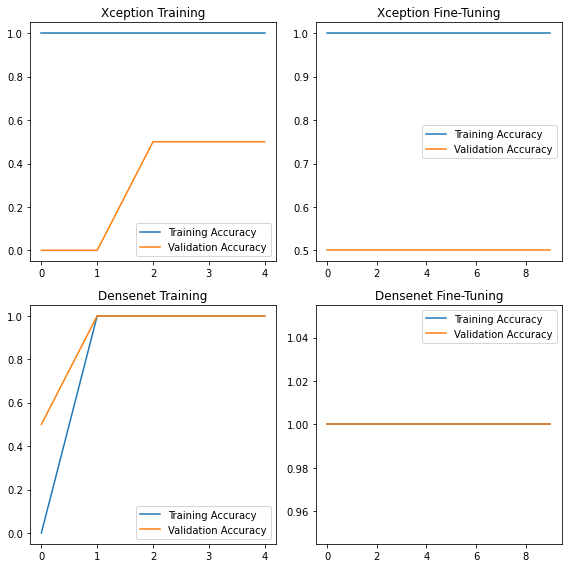

Found 2 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step
###############  Xception Metrics ################
Length of dataset: 2
Precision: 100.0%
Recall: 100.0%
F1 Score: 100.0%
1/1 [==============================] - 1s 555ms/step
###############  DenseNet Metrics ################
Length of dataset: 2
Precision: 50.0%
Recall: 100.0%
F1 Score: 66.7%
1/1 [==============================] - 2s 2s/step
###############  Ensemble Metrics ################
Length of dataset: 2
Precision: 50.0%
Recall: 100.0%
F1 Score: 66.7%


In [42]:
user_train("Example",prep=False)

1/1 [==============================] - 2s 2s/step
Prediction: 1


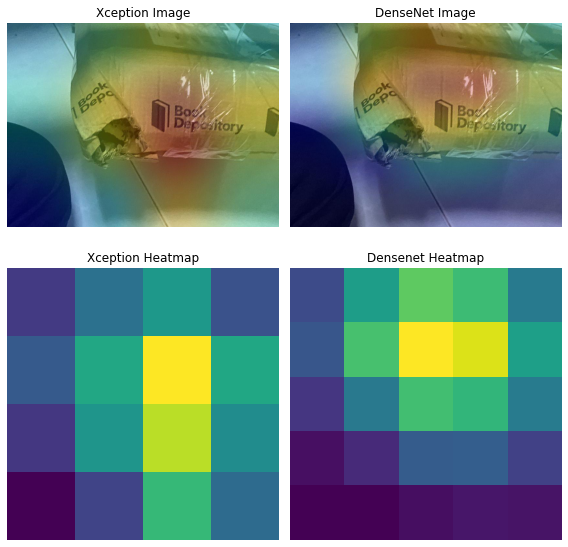

In [43]:
mailer_densenet_path = "C:/Users/teomz/Downloads/FYP/model/dense/dense11_09_23.h5"
mailer_xception_path = 'C:/Users/teomz/Downloads/FYP/model/xception/xception11_09_23.h5'

box_densenet_path =  "C:/Users/teomz/Downloads/FYP/model/dense/dense19_08_23.h5"
box_xception_path =  'C:/Users/teomz/Downloads/FYP/model/xception/xception19_08_23.h5'

mailer_0 = "C:/Users/teomz/Downloads/FYP/IMG_1687.jpg"
mailer_1 = 'C:/Users/teomz/Downloads/FYP/mailer_damaged.webp'

box_1 = "C:/Users/teomz/Downloads/FYP/IMG_1440.jpg"
box_0 = "C:/Users/teomz/Downloads/FYP/IMG_1712.jpg"

user_predict(box_1,box_xception_path,box_densenet_path)